# Import
First we import the necessary libraries and define functions

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from gudhi import RipsComplex
from gudhi import AlphaComplex
from gudhi.representations import Entropy
import gudhi as gd
import plotly.graph_objects as go
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec

def calculaDiagramaPersistencia(puntos,dimension):
    rips_complex = AlphaComplex(points=puntos) # 0pcion 1
    simplex_tree = rips_complex.create_simplex_tree(max_alpha_square=maxd)
    # rips_complex = RipsComplex(points=nube_puntos,max_edge_length=maxd) # Option 2
    # simplex_tree = rips_complex.create_simplex_tree()
    diagrama_persistente = simplex_tree.persistence()
    persistence = simplex_tree.persistence_intervals_in_dimension(dimension)
    return persistence

def limitaDiagrama(Diagrama,maximaFiltracion):
    infinity_mask = np.isinf(Diagrama)
    Diagrama[infinity_mask] = maximaFiltracion 
    return Diagrama

def calculaEntropia(persistentBarcode):
    l=[]
    for i in persistentBarcode:
        l.append(i[1]-i[0])
    L = sum(l)
    # print(f"L = {L}")
    p=l/L
    entropia=-np.sum(p*np.log(p))
    return round(entropia,4)

def dibujaNubePuntosInstante(time):
    instante = ps[time]
    x=instante[:,0]
    y=instante[:,1]
    angle=instante[:,2]

    plt.figure(figsize=(4, 4))

    plt.quiver(x, y, np.cos(angle), np.sin(angle), color="blue",
            angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5,label=f"Initial time: {time}")

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Point cloud in time: {time}')
    # plt.show()
    
def dibujaNubePuntos2Instantes(time1,time2):

    instante1 = ps[time1]
    instante2 = ps[time2]
    x1=instante1[:,0]
    y1=instante1[:,1]
    angle1=instante1[:,2]

    x2=instante2[:,0]
    y2=instante2[:,1]
    angle2=instante2[:,2]

    maxX=max(max(x1),max(x2)) + 1
    maxY=max(max(y1),max(y2)) + 1
    minX=min(min(x1),min(x2)) - 1
    minY=min(min(y1),min(y2)) - 1

    plt.figure(figsize=(4, 4))

    plt.quiver(x1, y1, np.cos(angle1), np.sin(angle1), color="blue",
            angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5,label=f"Initial time: {time1}")

    plt.quiver(x2, y2, np.cos(angle2), np.sin(angle2), color="red",
            angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5,label=f"End time: {time2}")
    for i in range(robots):
        plt.plot([x1[i], x2[i]], [y1[i], y2[i]], color='gray', linestyle='--',linewidth=0.5,alpha=0.5)
    plt.xlim(minX, maxX)
    plt.ylim(minY, maxY)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Point cloud in two times')
    plt.show()

def dibujaPersisteceDiagram(time):
    nube_puntos=ps[time,:,:2]
    persistence = calculaDiagramaPersistencia(nube_puntos,0)
    gd.plot_persistence_diagram(persistence)
    plt.title(f"Persistent diagram for time {time}")

def dibujaPersisteceBarcode(time):
    nube_puntos=ps[time,:,:2]
    persistence = calculaDiagramaPersistencia(nube_puntos,0)
    persistenciaL=limitaDiagrama(persistence,maxd)
    entropia=calculaEntropia(persistenciaL)
    gd.plot_persistence_barcode(persistenciaL)
    plt.title(f"Persistent barcode for time {time}; Entropy: {entropia}")
    


def dibujaEntropyTimeSerie(entropy):
    plt.plot(entropy,marker='o')
    plt.xlabel('Time')
    plt.ylabel('Entropy')
    plt.title(f'Topological entropy time series of persistent diagram')
    plt.grid(True)
    plt.show()

def dibujaEntropyTimeSerieInteractive(entropy):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=np.arange(0,100), 
            y=entropy,
            mode='lines+markers',
            marker=dict(size=8),
        )
    )

    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        xaxis_title='Time',
        yaxis_title='Entropy',
        title=f'Topological entropy time series of persistent diagram'
    )

    fig.show()

# Load the data. 

It corresponds to 100 point clouds with a time step of 0.1 seconds between each and 30 robots. We have the location of each robot and his angle of view. This data has been extracted from an experiment run of Navground (the software developed by SUPSI in WP3). https://idsia-robotics.github.io/navground/_build/html/index.html

In [3]:
ps = np.load("Robots.npy")
print(ps.shape) # 100 point clound with 30 robots and 3 features(x position, y position, angle view)
instantes=ps.shape[0]
robots=ps.shape[1]

ds = [pairwise_distances(X).flatten() for X in ps[:,:,:2]]
maxd = np.max(np.concatenate(ds))
print(maxd)

(100, 30, 3)
10.84102


We need to get the topology right. The topology of the point clouds can be inferred from several filterings, so we will use a fast and sparse (2D) one. First, we need to get an idea of the maximum filtering value to use, which we will approximate with the largest pairwise distance of the point clouds.

In [4]:
ds = [pairwise_distances(X).flatten() for X in ps[:,:,:2]]
maxd = np.max(np.concatenate(ds))
print(maxd)

10.84102


Now we can calculate the topological entropy of dimension 0 for each point cloud, for this we first calculate the persistence diagram, limit the bars that go to infinity and calculate the entropy. Finally we can plot the time series of the topology of how robots are located in each time and how they are moving.

Keep in mind that the first instant will have a very large entropy, or one of the largest, since by default Navground gives them very dispersed at the beginning of the experiment.

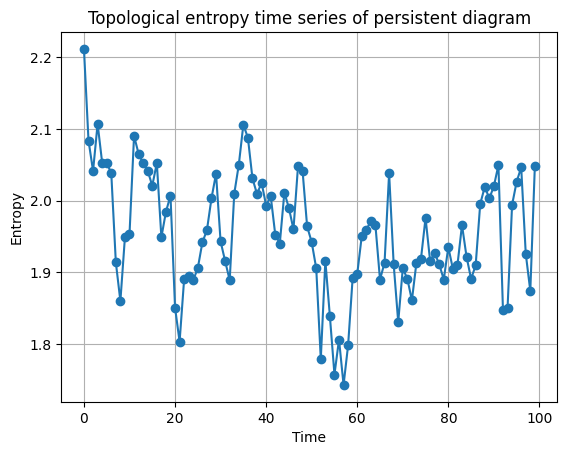

In [8]:
from gudhi.representations import DiagramSelector
entropias=[]
import gudhi as gd
for i in range(instantes):
    nube_puntos=ps[i,:,:2]
    persistence = calculaDiagramaPersistencia(nube_puntos,0)
    persistenciaL=limitaDiagrama(persistence,maxd)
    entropias.append(calculaEntropia(persistenciaL))
    # Option 2 with gudhi functions
    # persistenciaL = DiagramSelector(use=True).fit_transform([persistence]) # esta funcion elimina directamente los elementos del diagrama con infinitos, peude ser alternativa a limitaDiagrama
    # PE = Entropy()
    # entropias.append(PE.fit_transform([persistenciaL])[0][0])
    
dibujaEntropyTimeSerie(entropias)
dibujaEntropyTimeSerieInteractive(entropias)

It would be interesting to know what it means to have a peak of high/low entropy(for example, the time with biggest entropy: 35; and with the lowest entropy: 57) in terms of this time series, as well as the meaning of little or much entropy differences between two consecutive time instants(for example times 92,93 and 94 marked in red.​

# We compare the time instants of highest and lowest topological entropy.

In [10]:
sorted_indices = np.argsort(entropias)
indices_menores = sorted_indices[:9]
indices_mayores = sorted_indices[-9:]

Point clouds with lower entropy

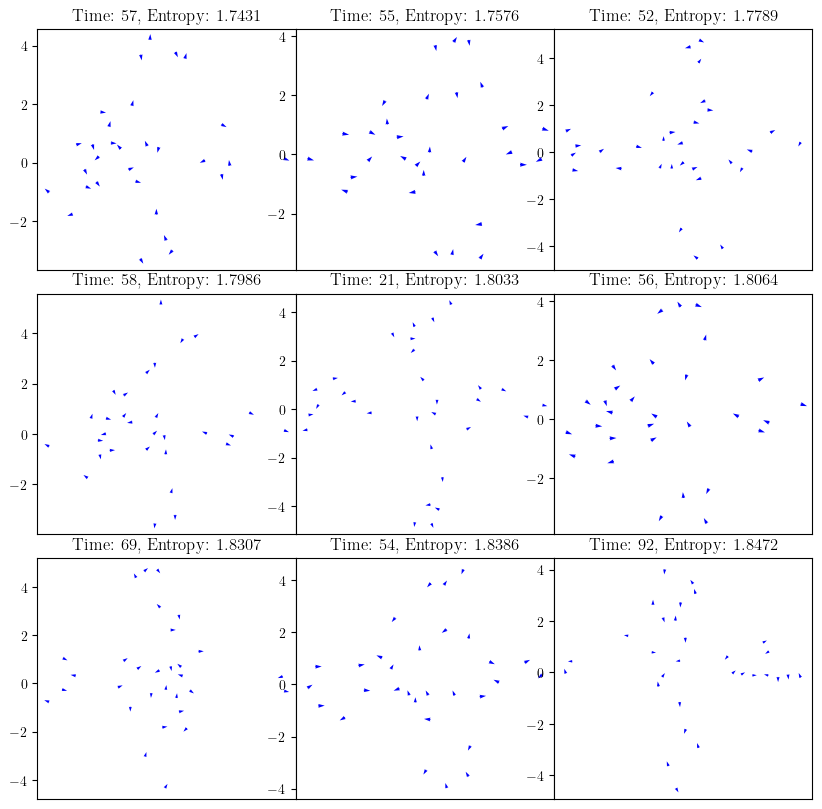

In [19]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.1)
for i in range(3):
    for j in range(3):
        instante = indices_menores[3*i+j]
        ax = plt.subplot(gs[i,j])
        ax.quiver(ps[instante][:,0], ps[instante][:,1], np.cos(ps[instante][:,2]), np.sin(ps[instante][:,2]), color="blue",
            angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5)
        plt.title(f"Time: {instante}, Entropy: {entropias[instante]}")
        plt.xticks([])
plt.show()

Point clouds with bigger entropy

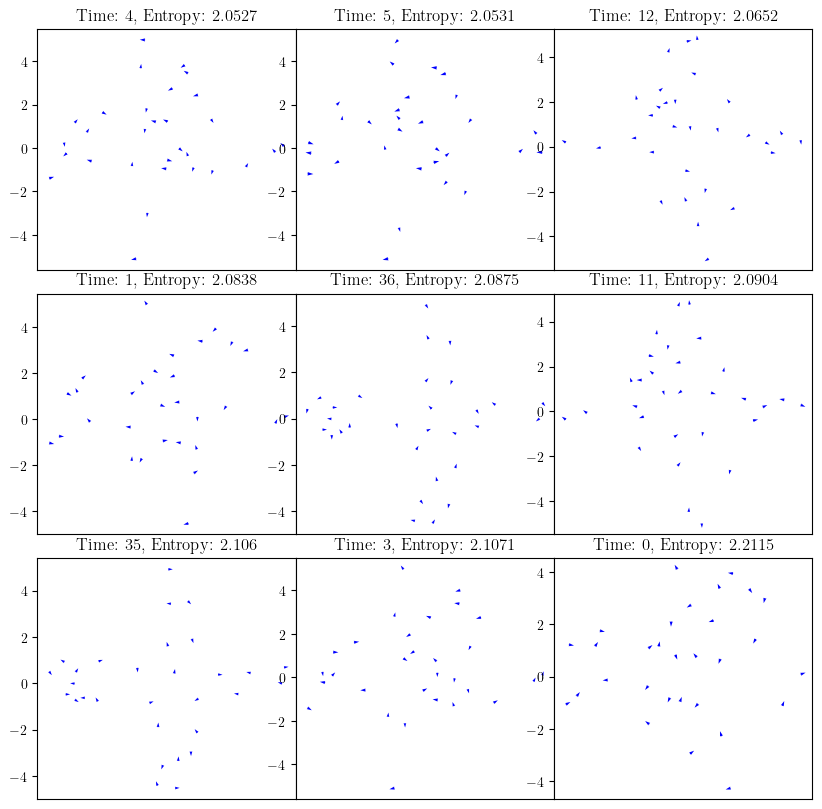

In [20]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.1)
for i in range(3):
    for j in range(3):
        instante = indices_mayores[3*i+j]
        ax = plt.subplot(gs[i,j])
        ax.quiver(ps[instante][:,0], ps[instante][:,1], np.cos(ps[instante][:,2]), np.sin(ps[instante][:,2]), color="blue",
            angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5)
        plt.title(f"Time: {instante}, Entropy: {entropias[instante]}")
        plt.xticks([])
plt.show()

Visualizing the persistent barcode

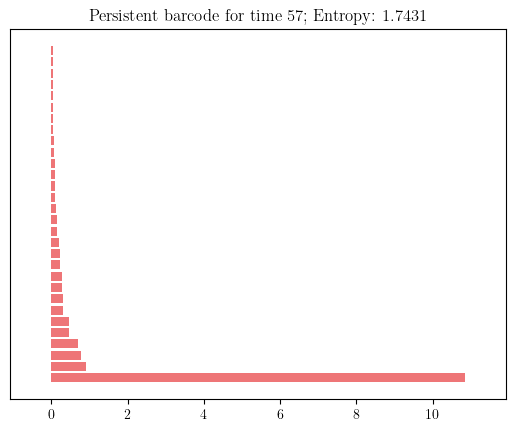

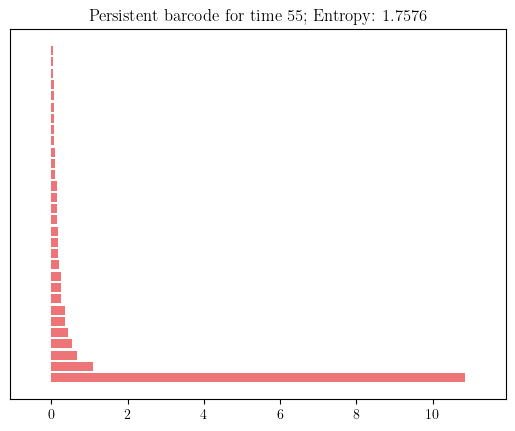

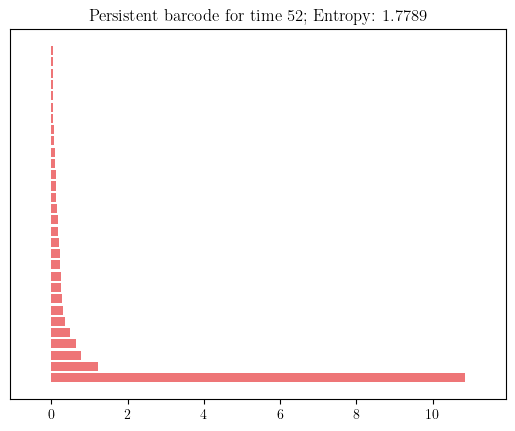

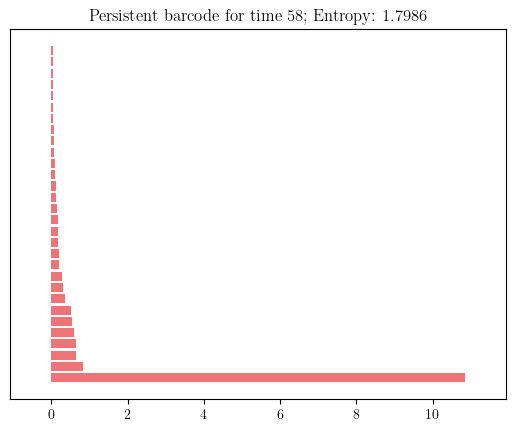

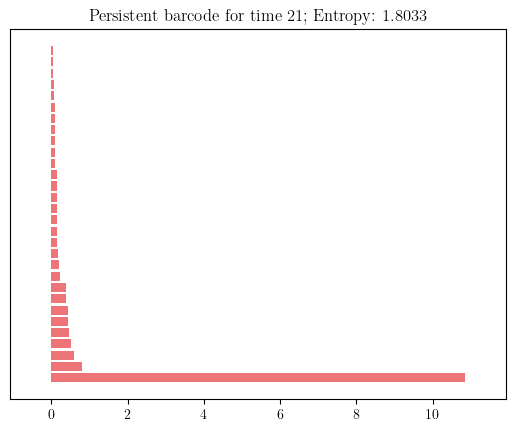

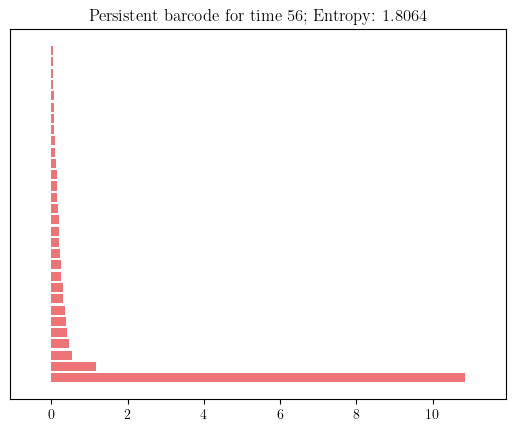

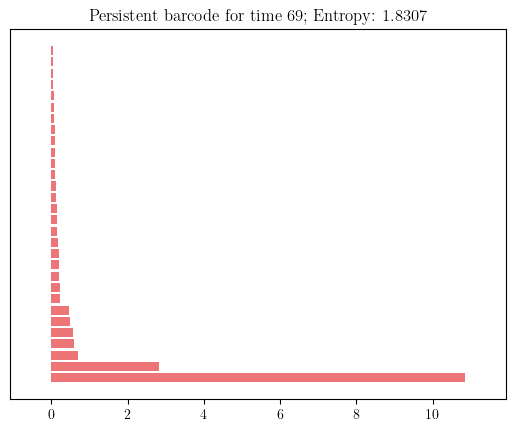

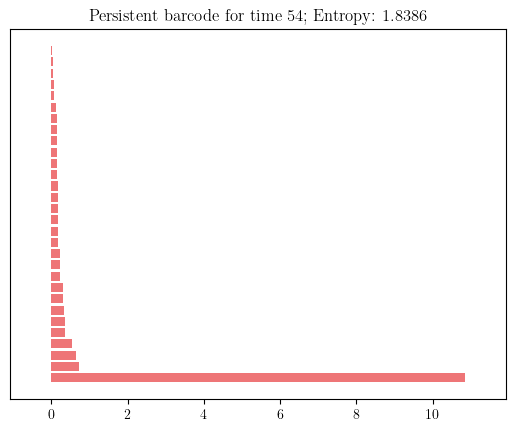

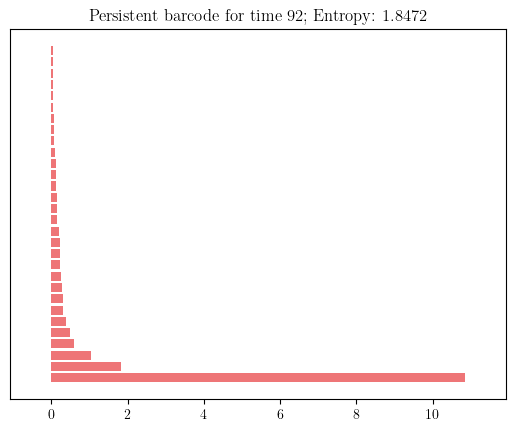

In [30]:
for i in range(9):
    dibujaPersisteceBarcode(indices_menores[i])

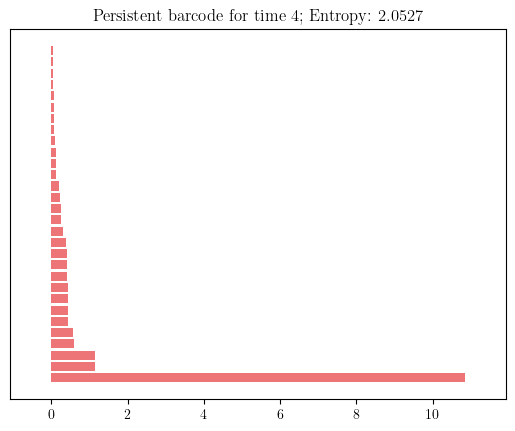

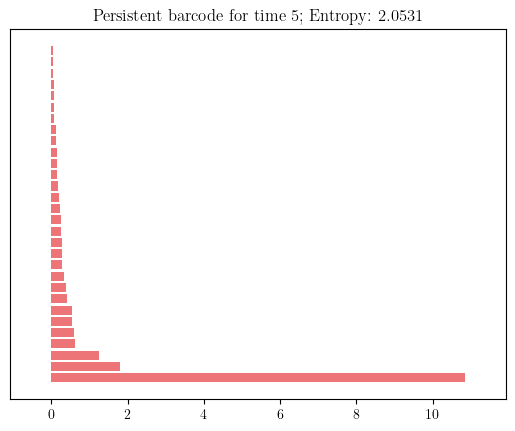

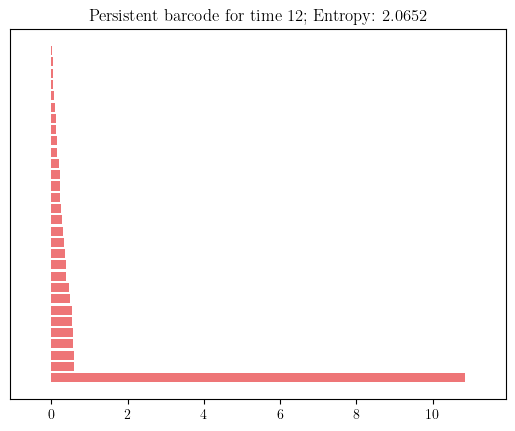

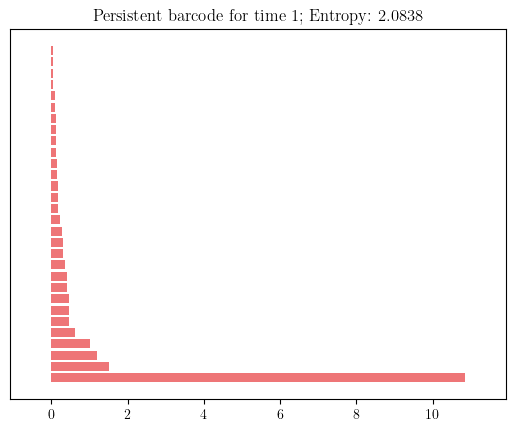

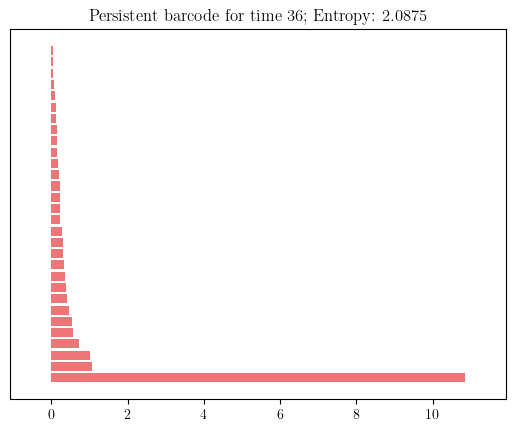

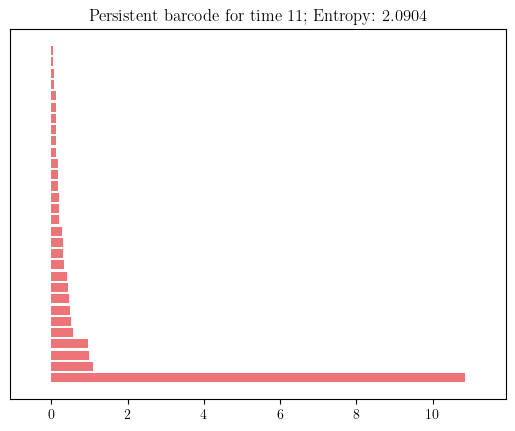

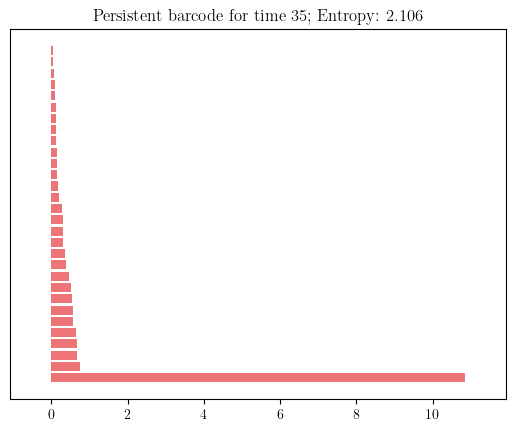

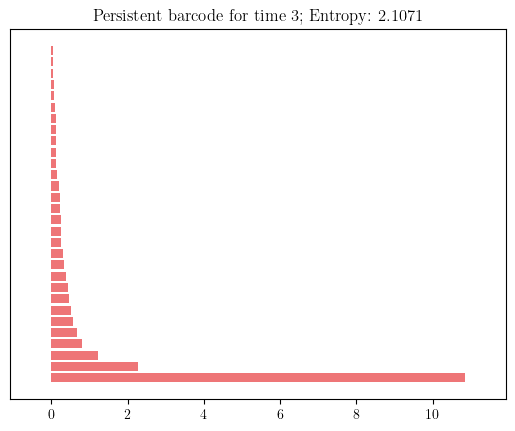

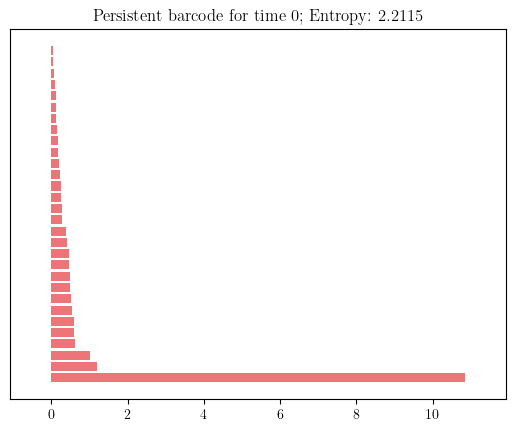

In [31]:
for i in range(9):
    dibujaPersisteceBarcode(indices_mayores[i])

We can say that: 

- Higher entropy:
    - Intervals in the persistence barcode are more evenly distributed in length
    - Suggests greater dispersion among the robots
- Lower entropy:
    - Intervals in the persistence barcode are less evenly distributed
    - Suggests that some robots form a group

# Comparing entropy difference between two consecutive time periods

Comparing times with very slight entropy change (92 and 93):

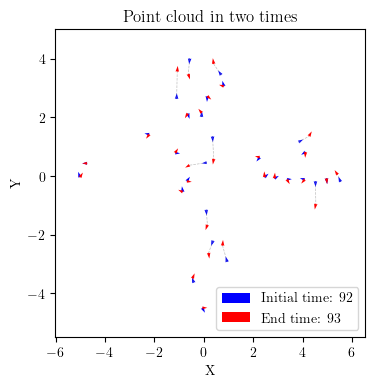

In [37]:
dibujaNubePuntos2Instantes(92,93)

Comparing times with larger entropy change (93 and 94):

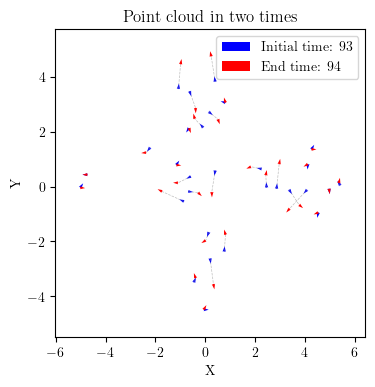

In [36]:
dibujaNubePuntos2Instantes(93,94)

Another example: Low difference in entropy between times 9 and 10 and bigger difference between times 10 and 11

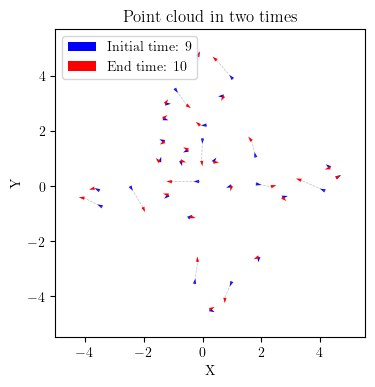

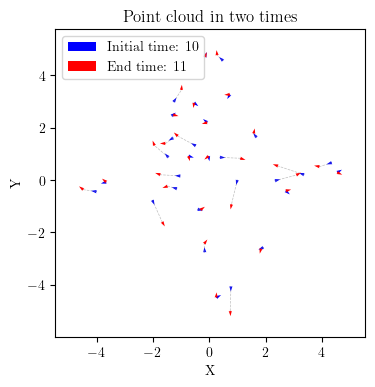

In [35]:
dibujaNubePuntos2Instantes(9,10)
dibujaNubePuntos2Instantes(10,11)

- Comparing times with very slight entropy 
    - Little to no movement of the robots
    - Suggests minimal change in position
- Comparing times with larger entropy change
    -  Significant movement and position change of the robots
    - Indicates a sharp change in entropy
- Conclusion:
    - Greater difference in entropy between two instants implies more movement and position change of the robots